In [7]:
import numpy as np
import keras
import pickle as pk
import matplotlib.pyplot as plt
import os
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import UpSampling2D, Input
from keras.models import Model

In [9]:
resnet = ResNet50(weights=None, include_top=True)

UnboundLocalError: local variable 'a' referenced before assignment

In [19]:
# Define model
inp = Input(shape=(32, 32, 3), name='image_input')
x = UpSampling2D(size =(7,7))(inp)
vgg = VGG16(weights='imagenet')

vgg.layers.pop()
vgg.outputs = [vgg.layers[-1].output]
vgg.layers[-1].outbound_nodes = []
vgg.summary()
output = vgg(x)

model = Model(inputs=inp, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
# Function to load a batch into memory
def load_batch(data_dir, batch_id):
    with open(os.path.join(data_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pk.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls

# Load the first batch
feats, labels = load_batch('cifar10', 1)
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label Id: 6 - Class: frog


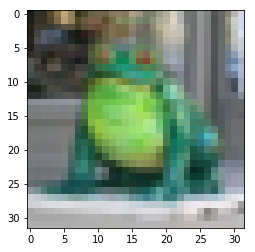

In [22]:
# Visualize images
sample_id = 19
sample_img = feats[sample_id]
sample_lbl = labels[sample_id]
print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl]))
plt.imshow(sample_img)

In [23]:
sample_img = preprocess_input(sample_img)

In [190]:
sample_size = 3000
sample_feats = feats[:sample_size,:,:,:]
sample_labels = labels[:sample_size]

In [191]:
import time
import json
start = time.time()
embeddings = model.predict(feats[:sample_size,:,:,:])
with open(f'embeddings/embeddings_{sample_size}.json', 'w') as outfile:
    json.dump(embeddings.tolist(), outfile)
print(time.time()-start)

1424.564667224884


In [177]:
def load_from_json(file:str):
    return json.loads(open(f'embeddings/{file}').read())

In [197]:
from sklearn.preprocessing import scale
def split_set(embeddings, labels, sample_size):
    n_embeddings= scale(embeddings)
    indices = np.random.permutation(sample_size)
    training_idx, dev_idx,test_idx = indices[:int(0.6*sample_size)], indices[int(0.6*sample_size):int(0.8*sample_size)],indices[int(0.8*sample_size):]
    feats_train,feats_dev, feats_test = n_embeddings[training_idx,:],n_embeddings[dev_idx,:], n_embeddings[test_idx,:]
    labels_train,labels_dev, labels_test = [np.array(labels[i]) for i in training_idx],[np.array(labels[i]) for i in dev_idx], [np.array(labels[i]) for i in test_idx]
    return [feats_train,feats_dev, feats_test],[labels_train,labels_dev, labels_test]

In [184]:
from sklearn.neighbors import KNeighborsClassifier
def train_knn_and_test(train,dev,labels_train,labels_dev):
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(train,labels_train)
    return knn,knn.score(train, labels_train), knn.score(dev, labels_dev)

In [186]:
from sklearn.decomposition import PCA
def train_pca(train_set, percentage=90):
    for i in range(50,min(sample_size,4096),50):
        pca = PCA(n_components=i)
        pca.fit(train_set)
        if np.sum(100*pca.explained_variance_ratio_) > percentage:
            return i,pca

In [ ]:
import pandas as pd

In [201]:
from os import listdir

for file in listdir('./embeddings'):
    if '.json' in file:
        df = pd.DataFrame(columns=['PCA','Train accuracy', 'Dev accuracy'])
        sample_size = int(file[file.index('_')+1:file.index('.')])
        embeddings = load_from_json(file)
        
        # Spit the data
        [feats_train,feats_dev, feats_test],[labels_train,labels_dev, labels_test] = split_set(
            embeddings, labels[:sample_size], sample_size)

        # Train knn
        knn, knn_train_score, knn_test_score = train_knn_and_test(feats_train,feats_dev,labels_train,labels_dev)
        
        df.loc[0] = [0,knn_train_score,knn_test_score ]
        
        # Fit pca
        i,pca = train_pca(feats_train)
        print(f'Trained pca with {i} components')
        
        # Train knn
        knn, knn_train_score, knn_test_score = train_knn_and_test(pca.transform(feats_train),pca.transform(feats_dev),labels_train,labels_dev)
        df.loc[1] = [1,knn_train_score,knn_test_score]
        print(df)

Trained pca with 250 components
   PCA  Train accuracy  Dev accuracy
0  0.0        0.523333         0.355
1  1.0        0.548333         0.320
Trained pca with 500 components
   PCA  Train accuracy  Dev accuracy
0  0.0        0.563333      0.388333
1  1.0        0.575000      0.395000


In [207]:
from sklearn.metrics import confusion_matrix
confusion_matrix(knn.predict(pca.transform(feats_dev)), labels_dev)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

array([[23,  6,  4,  3,  2,  2,  3,  2,  6,  4],
       [ 4, 23,  6,  2,  2,  3,  3,  4,  4,  8],
       [ 3,  2, 13,  3,  4,  2,  2,  2,  0,  0],
       [ 2,  4,  7, 15,  3, 12,  3,  2,  4,  2],
       [ 1,  0, 12, 11, 24,  9, 17, 10,  4,  0],
       [ 5,  5,  3, 10,  4, 15,  6,  9,  1,  2],
       [ 1,  5,  9,  8,  5,  4, 28,  0,  1,  2],
       [ 2,  5,  3,  0,  8,  3,  2, 13,  2,  7],
       [17,  1,  0,  0,  1,  1,  1,  1, 40,  1],
       [ 6, 12,  1,  3,  3,  2,  4,  3,  5, 43]])